코랩 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 디렉토리가 ~~/notebooks가 되게끔 설정해주세요
%cd /content/drive/MyDrive/DSL/25-1/과제/[0227]CNN_JunsikCHU/notebooks

/content/drive/MyDrive/DSL/25-1/과제/[0227]CNN_JunsikCHU/notebooks


# 경로 설정 및 라이브러리/모듈 불러오기

In [ ]:
import os

# 디렉토리가 ~~/notebooks가 되게끔 설정해주세요
# os.chdir()
print(os.getcwd())

/content/drive/MyDrive/DSL/25-1/과제/[0227]CNN_JunsikCHU/notebooks


In [ ]:
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(ROOT_DIR, "data")
weights_dir = os.path.join(ROOT_DIR, "weights")
results_dir = os.path.join(ROOT_DIR, "results")
config_path = os.path.join(ROOT_DIR, "configs", "config.yaml")
metadata_path = os.path.join(ROOT_DIR, "data", "metadata.csv")

sys.path.append(os.path.join(ROOT_DIR, "models"))
sys.path.append(os.path.join(ROOT_DIR, "scripts"))
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [ ]:
from CustomDataset import CustomImageDataset
from resnet import ResNet50

import pandas as pd
import numpy as np

import yaml

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# 하이퍼파라미터 및 기본 설정들

**config.yaml**에 지정해줬던 하이퍼파라미터들을 가져옵시다.

In [ ]:
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

batch_size, lr, epochs \
    = config["no_augmentation"]["hyperparameters"]["batch_size"], \
      float(config["no_augmentation"]["hyperparameters"]["learning_rate"]), \
      config["no_augmentation"]["hyperparameters"]["num_epochs"]

In [ ]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# num_workers는 dataset의 데이터를 gpu로 전송할 때 필요한 전처리를 수행할 때 사용하는 subprocess의 수입니다
# 참고: https://velog.io/@seokjin1013/PyTorch-numworkers%EC%97%90-%EA%B4%80%ED%95%98%EC%97%AC
num_workers = min(4, os.cpu_count() // 2)
print(num_workers)

1


# train, val, test DataLoader 초기화

In [ ]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv("/content/drive/MyDrive/DSL/25-1/과제/[0227]CNN_JunsikCHU/data/metadata.csv")


# **✅ 2. 데이터 분할 (Train : Val : Test = 6 : 2 : 2, stratify 없이)**
train, val_test = train_test_split(meta_data, train_size=0.6, random_state=2025)
val, test = train_test_split(val_test, train_size=0.5, random_state=2025)

# **✅ 3. Dataset 생성**
train_dataset = CustomImageDataset(data_dir=data_dir, df=train, augment=False)
val_dataset = CustomImageDataset(data_dir=data_dir, df=val, augment=False)
test_dataset = CustomImageDataset(data_dir=data_dir, df=test, augment=False)

# **✅ 4. DataLoader 설정**
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 모델 초기화, 손실함수 및 optimizer 지정

In [ ]:
model = ResNet50(num_classes=1)  # 이진 분류이므로 num_classes=1 설정
model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [ ]:
# **✅ 2. 손실 함수 (Binary Cross Entropy with Logits)**
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss는 Sigmoid를 포함한 BCE 손실 함수

# **✅ 3. Adam 옵티마이저**
optimizer = optim.Adam(model.parameters(), lr=lr)  # 모델의 모든 파라미터를 최적화

# Train

In [ ]:
import os
import torch

# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# 모든 epoch에서의 loss와 accuracy들을 저장할 리스트들
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for curr_epoch in range(epochs):  # iterate over all EPOCHS
    running_loss, total_correct, total_samples = 0, 0, 0  # 현재 epoch에서의 train_loss와 train_accuracy를 계산하기 위한 변수들

    model.train()  # 모델을 학습 모드로 설정

    for batch_idx, (img, label) in enumerate(train_loader):  # iterate over all BATCHES
        # GPU로 데이터 이동
        img, label = img.to(device), label.to(device).float()  # label을 float으로 변환

        # Forward Propagation
        pred = model(img)

        # 손실함수 계산
        loss = criterion(pred, label.view(-1, 1))  # label 크기 맞추기

        # 누적된 기울기 초기화 및 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 해당 Batch에서의 loss를 running_loss 변수에 누적
        running_loss += loss.item()

        # Accuracy 계산 (이진 분류)
        predicted = (torch.sigmoid(pred) > 0.5).float()
        total_correct += (predicted == label.view(-1, 1)).sum().item()
        total_samples += label.size(0)

    # 모든 Batch를 순회한 이후 최종적인 train_loss, train_accuracy 계산
    train_loss = running_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Validation 시작
    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():  # 학습 중이 아니므로 gradient 연산을 방지
        running_loss, total_correct, total_samples = 0, 0, 0  # 현재 epoch에서의 val_loss와 val_accuracy 계산 변수들

        for img, label in val_loader:  # iterate over all BATCHES
            # GPU로 데이터 이동
            img, label = img.to(device), label.to(device).float()

            # Forward Propagation
            pred = model(img)

            # 손실함수 계산
            loss = criterion(pred, label.view(-1, 1))

            # 해당 Batch에서의 loss를 running_loss 변수에 누적
            running_loss += loss.item()

            # 예측값 및 Accuracy 계산
            predicted = (torch.sigmoid(pred) > 0.5).float()
            total_correct += (predicted == label.view(-1, 1)).sum().item()
            total_samples += label.size(0)

        # 모든 Batch를 순회한 이후 최종적인 val_loss, val_accuracy 계산
        val_loss = running_loss / len(val_loader)
        val_accuracy = total_correct / total_samples

    model.train()  # 모델을 다시 학습 모드로 설정

    # 현재 epoch에서의 결과 출력
    print(f"Epoch [{curr_epoch + 1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    # 리스트에 저장
    train_loss_list.append(train_loss)
    valid_loss_list.append(val_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(val_accuracy)

    # 가장 작은 validation loss를 가졌을 때의 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weights_dir, "best_model_no_augmentation.pth"))

print("✅ Training Completed!")


Epoch [1/10] | Train Loss: 1.4777 | Train Accuracy: 0.5506 | Val Loss: 1.2934 | Val Accuracy: 0.5117
Epoch [2/10] | Train Loss: 0.6652 | Train Accuracy: 0.6372 | Val Loss: 4.3684 | Val Accuracy: 0.6583
Epoch [3/10] | Train Loss: 0.6084 | Train Accuracy: 0.7244 | Val Loss: 0.6369 | Val Accuracy: 0.6533
Epoch [4/10] | Train Loss: 0.6312 | Train Accuracy: 0.7072 | Val Loss: 0.4091 | Val Accuracy: 0.8117
Epoch [5/10] | Train Loss: 0.4628 | Train Accuracy: 0.7872 | Val Loss: 0.6479 | Val Accuracy: 0.8233
Epoch [6/10] | Train Loss: 0.3938 | Train Accuracy: 0.8283 | Val Loss: 0.4693 | Val Accuracy: 0.8317
Epoch [7/10] | Train Loss: 0.3552 | Train Accuracy: 0.8594 | Val Loss: 0.5620 | Val Accuracy: 0.8700
Epoch [8/10] | Train Loss: 0.3280 | Train Accuracy: 0.8628 | Val Loss: 0.3535 | Val Accuracy: 0.8800
Epoch [9/10] | Train Loss: 0.2835 | Train Accuracy: 0.8789 | Val Loss: 0.2680 | Val Accuracy: 0.9033
Epoch [10/10] | Train Loss: 0.2794 | Train Accuracy: 0.9017 | Val Loss: 0.2730 | Val Accura

# Train 결과 시각화 및 그래프 저장

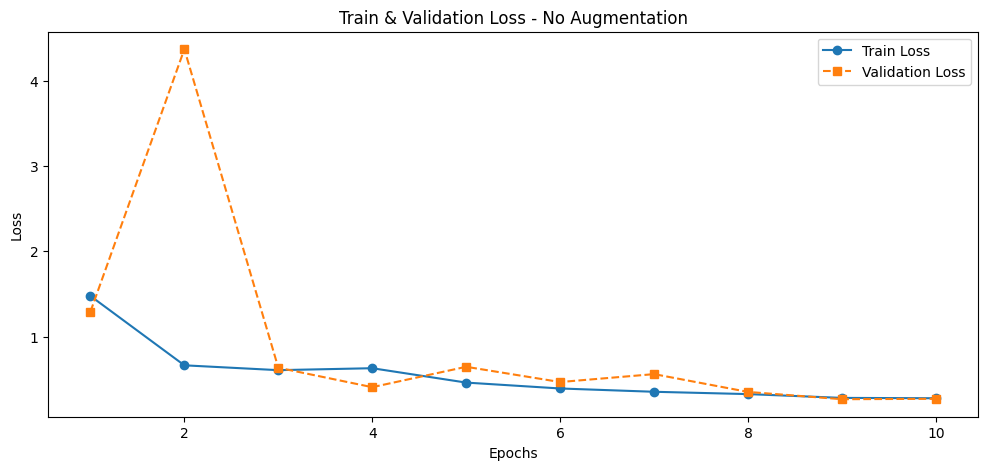

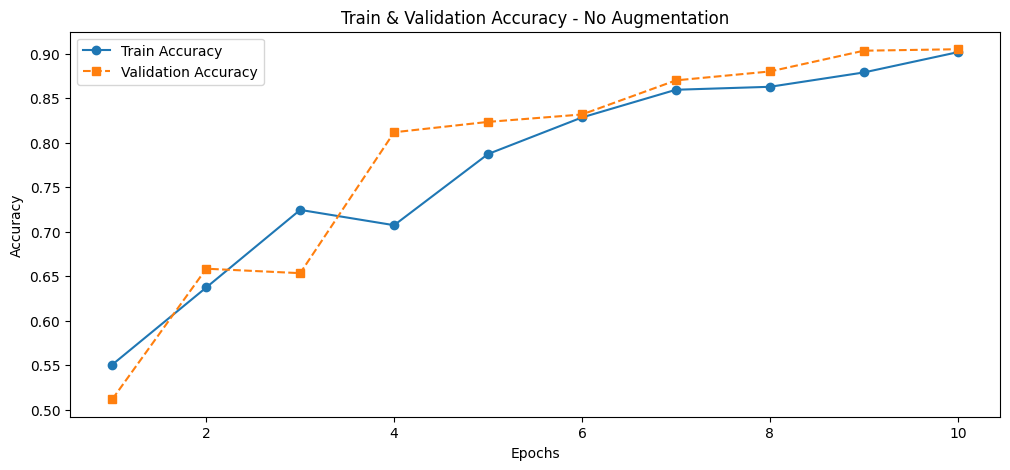

In [ ]:
# Train Loss & Validation Loss 그래프 시각화 및 저장
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), valid_loss_list, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Validation Loss - No Augmentation')
plt.legend()
plt.savefig(os.path.join(results_dir, "train_validation_loss_no_augmentation.png"))
plt.show()
plt.close()

# Train Accuracy & Validation Accuracy 그래프 시각화 및 저장
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), valid_accuracy_list, label='Validation Accuracy', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy - No Augmentation')
plt.legend()
plt.savefig(os.path.join(results_dir, "train_validation_accuracy_no_augmentation.png"))
plt.show()
plt.close()

# Test 및 Test 결과 시각화

In [ ]:
# **✅ 1. ResNet50 모델 초기화**
trained_model = ResNet50(num_classes=1)  # 이진 분류이므로 num_classes=1 설정

# **✅ 2. 저장된 weight 로드**
trained_model.load_state_dict(torch.load(os.path.join(weights_dir, "best_model_no_augmentation.pth")))

# **✅ 3. 모델을 evaluation 모드로 설정**
trained_model.eval()
trained_model.to(device)

<ipython-input-38-0583a6309012>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(os.path.join(weights_dir, "best_model_no_augmentati

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [ ]:
all_labels = []
all_predictions = []

# **✅ 4. Test 데이터로 평가**
with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않음
    for image, label in test_loader:  # iterate over all test batches
        # GPU에 데이터 이동
        image, label = image.to(device), label.to(device).float()

        # **✅ 5. Forward Propagation**
        pred = trained_model(image)

        # **✅ 6. 예측값 계산**
        predicted = (torch.sigmoid(pred) > 0.5).float()

        # **✅ 7. 리스트에 저장**
        all_labels.append(label)
        all_predictions.append(predicted)

# **✅ 8. 리스트를 하나의 텐서로 변환**
all_labels = torch.cat(all_labels).cpu().numpy().tolist()
all_predictions = torch.cat(all_predictions).cpu().numpy().tolist()

Accuracy: 89.67%


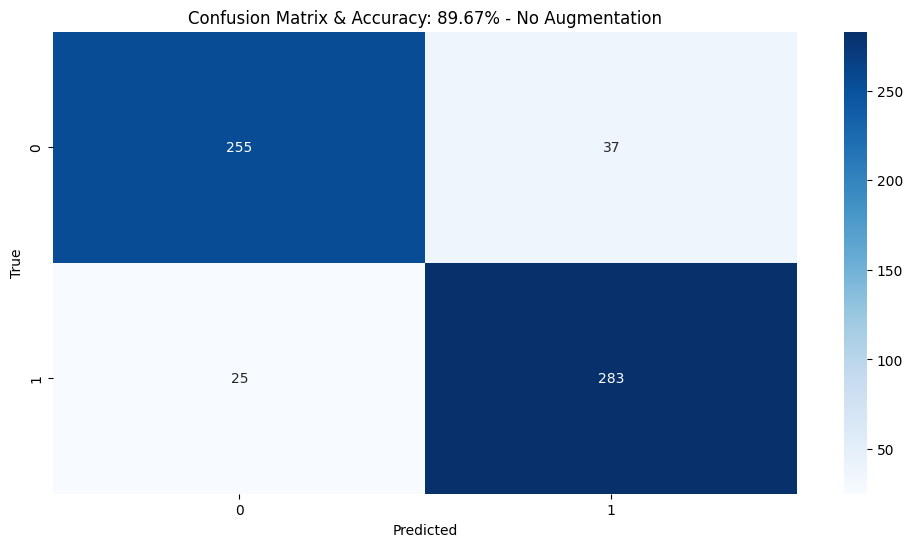

In [ ]:
# Accuracy 계산 및 Confusion Matrix 계산
accuracy = accuracy_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

# Confusion Matrix 시각화 및 저장

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix & Accuracy: {accuracy * 100:.2f}% - No Augmentation')
plt.savefig(os.path.join(results_dir, "test_accuracy_no_augmentation.png"))
plt.show()
plt.close()